In [1]:
import json
import os, os.path
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Input directories and config parameters

Working with > 800k files is a pain. Specifically, your filesystem will not have a good time indexing all of the files in the directory. This makes any sort of live `glob` style approach fail miserably. Thus I had to preprocess everything in steps to be able to hand the volume of data.

I generated the `final_processed.pickle` file by:
    
    1) Iterate over the full downloaded collection, generate hashes, and store all of these values into a pickled dictionary.
    
    2) Iterate over the condensed downloaded collection, and for each file:
        2.1) Generate a hash for it
        2.2) Use this file to generate a "base url" for any files in the full collection
        2.3) Search for any url which had this base url, and take this hash value and add it to the dataframe
        
The schema for the dataframe is `[filename, parent_filename, hash]`, where `filename` is the actual file downloaded, `parent_filename` is the "base url" for that file (if applicable; I filtered out any files which matched the base url as well as labled the base url as the `parent_filename` for the parent), and `hash` is the corresponding SHA1 hash of the file.

In [2]:
plt.rcParams['figure.figsize'] = [15, 10]

# Inputfile
INPUT_FILE = 'final_processed.pickle'
INPUT_HTTP_STATUS = 'js_status.csv'

In [3]:
# For the hash data
df = pd.read_pickle(INPUT_FILE)
df.shape

(386559, 3)

I also have a file to inspect the HTTP response status for each file. I check the aggregate counts for each status code below.

In [4]:
# For the status data
statuses = pd.read_csv(INPUT_HTTP_STATUS)
statuses = statuses[statuses['status'] != statuses['url']].dropna(how='all', axis=1)#.drop('Unamed')

statuses_group = statuses.groupby('status').agg('count').sort_values(by=('url'), ascending=False)

In [5]:
statuses_group.head(25)

,url
status,
200,143825
404,16272
403,3527
400,710
503,369
500,233
None,232
410,103
[Errno 104] Connection reset by peer,91


First input the files. Note that the total size of the full dataset is on the order of 8\*10^5, wheras the condensed dataset is closer to 1.3\*10^5. Immediately noted that a lot of files were discarded using this method.

# First Look at Counts

I begin by just inspecting the counts of the dataframes to see which are the worst offenders with generating excessive queries.

Mean number of counts per parent filename: 2.848377446356991
--------------------------------------------------------------------------------
                                                   filename    hash
                                                      count   count
parent_filename                                                    
staticxx-facebook-com-connect-xd-arbiter-r-ly4e...   102349  102349
ads-pubmatic-com-adserver-js-showad-js.txt            10695   10695
z-moatads-com-keplerpaypaldcm168224283233-moata...     6771    6771
script-bangdom-com-pjs-2-6-8-js.txt                    6212    6212
z-moatads-com-quantcastv2691176990399-moatad-js...     5223    5223
tps30-doubleverify-com-visit-js.txt                    4634    4634
rtb0-doubleverify-com-verify-js.txt                    2468    2468
static-criteo-net-js-ld-publishertag-js.txt            1778    1778
s7-addthis-com-js-300-addthis-widget-js.txt            1530    1530
assets-pinterest-com-js-pinit-main-js.txt 

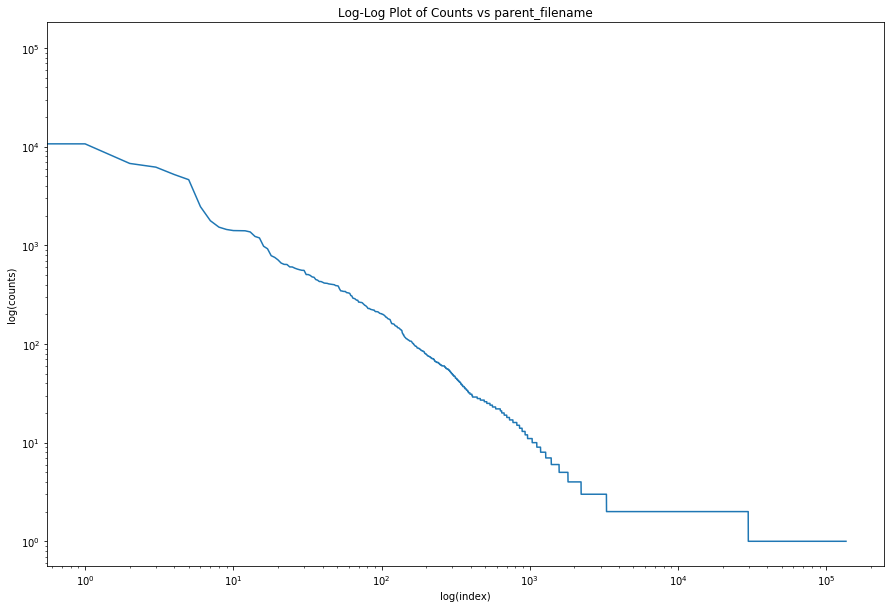

Percent of files that are not unique:	21.89%.
Percent of files that have > 2 queries:	2.42%.


In [6]:
tmp = df.groupby('parent_filename').agg(['count'])
tmp = tmp.sort_values(by=('hash','count'), ascending=False)
counts = tmp['filename']['count'].values # get array of values
print("Mean number of counts per parent filename: {}\n".format(tmp['filename']['count'].mean()) + "-" * 80)
print(tmp.head(20))
print("-" * 80)

plt.plot(counts)
plt.title('Log-Log Plot of Counts vs parent_filename')
plt.ylabel('log(counts)')
plt.xlabel('log(index)')
plt.xscale('log')
plt.yscale('log')
plt.show()

ratio1 = 100 * tmp[tmp['filename']['count'] > 1].shape[0] / tmp.shape[0]
ratio2 = 100 * tmp[tmp['filename']['count'] > 2].shape[0] / tmp.shape[0]

print("Percent of files that are not unique:\t{:0.2f}%.\nPercent of files that have > 2 queries:\t{:0.2f}%.".format(ratio1, ratio2))

Immediately we can see that there are a small but significant number of websites that add on huge amounts of queries. The worst offender is facebook, which makes sense considering that this *probably* corresponds to facebook making personalized requests to its users. 

*Note that the counts for both filenames and hashes are the same at this stage; next stage will be grouping by the hashes to compare how many of the downloaded javascript files are actually identical*.

# Analysis of Hashes

We are interested in quantifying the properties of hashes within a group of a given `parent_url`. I quantify three metrics: 

1) `number_of_hashes` is just the aggregate count of the group, i.e. how many members are in that group. 

2) `number_of_distinct_hashes` is as the variable implies, the count of the unique number of hashes in a group, including the `parent_filename`'s hash.

3) `ratio_different` is the ratio of hashes different than `parent_filename`'s hash, compared to the total number of hashes excluding `parent_filename`'s hash.

I tossed out any group with only one 

*Note that next cell takes a litle bit of time to finish.*

In [7]:
parent_group = df.groupby('parent_filename')

def group_compare(group):

    number_of_hashes = len(group)
    number_of_distinct_hashes = len(group.groupby('hash'))

    # Select hash corresponding to parent file (rip out string value)
    selected_hash = group[group['parent_filename'] == group['filename']]['hash'].values[0]
    
    # Compare the rest of the files in that group (omit 1st file) to that hash, aggregate counts
    compared_hashes = group[group['parent_filename'] != group['filename']]
    compared_hashes = compared_hashes[compared_hashes['hash'] != selected_hash].shape[0]
    ratio = float(compared_hashes) / float((number_of_hashes - 1))

    x = {
        'parent_filename':group['parent_filename'].values[0],
        'number_of_hashes':number_of_hashes,
        'number_of_distinct_hashes':number_of_distinct_hashes,
        'ratio_different':ratio
    }
    
    """
    if compared_hashes > 0:
        print(compared_hashes)
        print(group)
        print(x)
        print("-"*80)
    """
    
    return x

new_df_list = []
for name, group in parent_group:
    if len(group) > 1:
        new_df_list.append(group_compare(group))
    
output_df = pd.DataFrame(new_df_list)

In [8]:
# Sanity check to make sure not all values for the ratio are 1
sorted_tmp = output_df.sort_values(by='ratio_different', ascending=False)
sorted_tmp[sorted_tmp['ratio_different'] < 1].head(5)

,number_of_distinct_hashes,number_of_hashes,parent_filename,ratio_different
3686,181,184,cdn-onthe-io-io-js.txt,0.989071
17815,17,18,store-edgecast-steamstatic-com-public-javascri...,0.941176
3268,2,11,cdm-cursecdn-com-js-futhead-cdmfactorem-min-js...,0.900000
4721,17,19,code-etracker-com-t-js.txt,0.888889
17819,16,18,store-edgecast-steamstatic-com-public-shared-j...,0.882353


Great! Lets check out the various properties and see which are the worst offenders by these metrics.

In [9]:
sorted_ratio = output_df.sort_values(by=['ratio_different', 'number_of_distinct_hashes'], ascending=False)
sorted_num_hashes = output_df.sort_values(by='number_of_hashes', ascending=False)
sorted_num_distinct_hashes = output_df.sort_values(by='number_of_distinct_hashes', ascending=False)

## Sorted by ratio (and number of hashes)

In [10]:
sorted_ratio.head(10)

,number_of_distinct_hashes,number_of_hashes,parent_filename,ratio_different
19628,4634,4634,tps30-doubleverify-com-visit-js.txt,1.0
14728,2468,2468,rtb0-doubleverify-com-verify-js.txt,1.0
945,604,604,apis-google-com-js-plusone-js.txt,1.0
19627,559,559,tps-doubleverify-com-visit-js.txt,1.0
944,475,475,apis-google-com-js-platform-js.txt,1.0
3309,430,430,cdn-adrta-com-p-js.txt,1.0
14729,390,390,rtb0-doubleverify-com-verifyc-js.txt,1.0
18438,221,221,tags-news-com-au-prod-utrack-utrack-js.txt,1.0
502,212,212,adnz-co-cis-script-js.txt,1.0
5623,194,194,da-admission-net-admission-displayad-js.txt,1.0


## Sorted by number of hashes

In [11]:
sorted_num_hashes.head(10)

,number_of_distinct_hashes,number_of_hashes,parent_filename,ratio_different
17744,3,102349,staticxx-facebook-com-connect-xd-arbiter-r-ly4...,1.0
544,1,10695,ads-pubmatic-com-adserver-js-showad-js.txt,0.0
29367,1,6771,z-moatads-com-keplerpaypaldcm168224283233-moat...,0.0
15469,1,6212,script-bangdom-com-pjs-2-6-8-js.txt,0.0
29498,1,5223,z-moatads-com-quantcastv2691176990399-moatad-j...,0.0
19628,4634,4634,tps30-doubleverify-com-visit-js.txt,1.0
14728,2468,2468,rtb0-doubleverify-com-verify-js.txt,1.0
16966,1,1778,static-criteo-net-js-ld-publishertag-js.txt,0.0
15239,1,1530,s7-addthis-com-js-300-addthis-widget-js.txt,0.0
1369,1,1449,assets-pinterest-com-js-pinit-main-js.txt,0.0


## Sorted by number of distinct hashes

In [12]:
sorted_num_distinct_hashes.head(10)

,number_of_distinct_hashes,number_of_hashes,parent_filename,ratio_different
19628,4634,4634,tps30-doubleverify-com-visit-js.txt,1.0
14728,2468,2468,rtb0-doubleverify-com-verify-js.txt,1.0
945,604,604,apis-google-com-js-plusone-js.txt,1.0
19627,559,559,tps-doubleverify-com-visit-js.txt,1.0
944,475,475,apis-google-com-js-platform-js.txt,1.0
3309,430,430,cdn-adrta-com-p-js.txt,1.0
14729,390,390,rtb0-doubleverify-com-verifyc-js.txt,1.0
18438,221,221,tags-news-com-au-prod-utrack-utrack-js.txt,1.0
502,212,212,adnz-co-cis-script-js.txt,1.0
5623,194,194,da-admission-net-admission-displayad-js.txt,1.0


Let's visualize some of these results, compared with the other metrics. 

# Sorted by Number Of Distinct Hashes

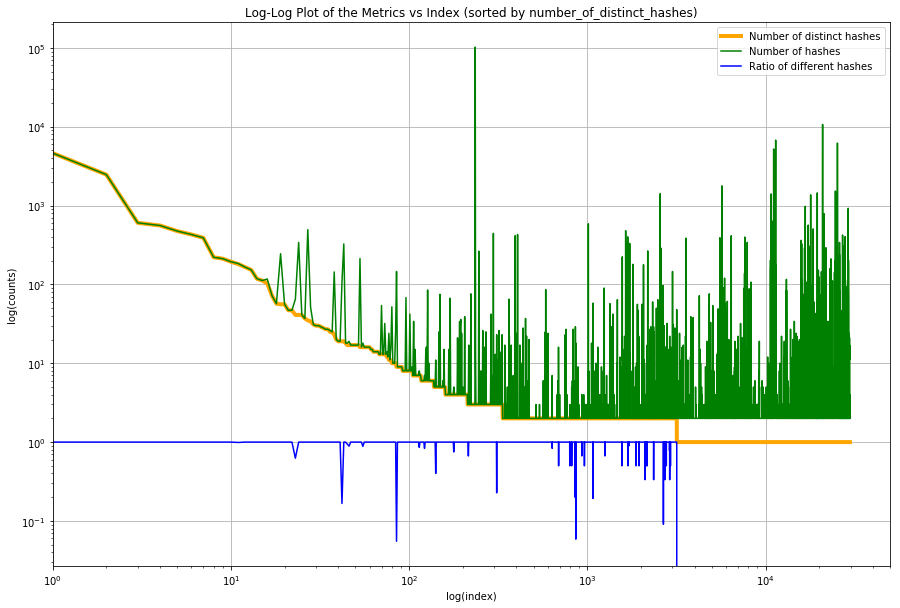

In [13]:
line0 = range(len(sorted_num_distinct_hashes) + 1)
line1 = np.insert(sorted_num_distinct_hashes['ratio_different'].values, 0, 1, axis=0)
line2 = np.insert(sorted_num_distinct_hashes['number_of_hashes'].values, 0, 1, axis=0)
line3 = np.insert(sorted_num_distinct_hashes['number_of_distinct_hashes'].values, 0, 1, axis=0)

plt.plot(line0,line3, linewidth=4,  color='orange')
plt.plot(line0,line2, color='green')
plt.plot(line0,line1, color='blue')

plt.title('Log-Log Plot of the Metrics vs Index (sorted by number_of_distinct_hashes)')
plt.ylabel('log(counts)')
plt.xlabel('log(index)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1)
plt.legend(["Number of distinct hashes", "Number of hashes", "Ratio of different hashes"])
plt.grid()
plt.show()

# Sorted by Number Of Hashes

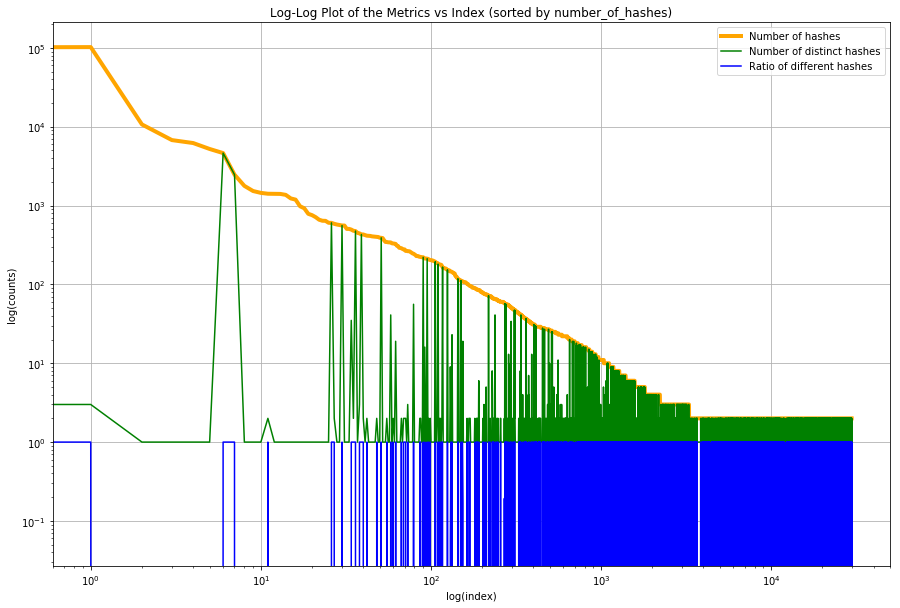

In [14]:
line0 = range(len(sorted_num_hashes) + 1)
line1 = np.insert(sorted_num_hashes['ratio_different'].values, 0, 1, axis=0)
line2 = np.insert(sorted_num_hashes['number_of_hashes'].values, 0, 1, axis=0)
line3 = np.insert(sorted_num_hashes['number_of_distinct_hashes'].values, 0, 1, axis=0)

plt.plot(line0,line2, linewidth=4,  color='orange')
plt.plot(line0,line3, color='green')
plt.plot(line0,line1, color='blue')

plt.title('Log-Log Plot of the Metrics vs Index (sorted by number_of_hashes)')
plt.ylabel('log(counts)')
plt.xlabel('log(index)')
plt.xscale('log')
plt.yscale('log')
plt.legend(["Number of hashes", "Number of distinct hashes", "Ratio of different hashes"])
plt.grid()
plt.show()

# Sorted by Ratio of Different Hashes

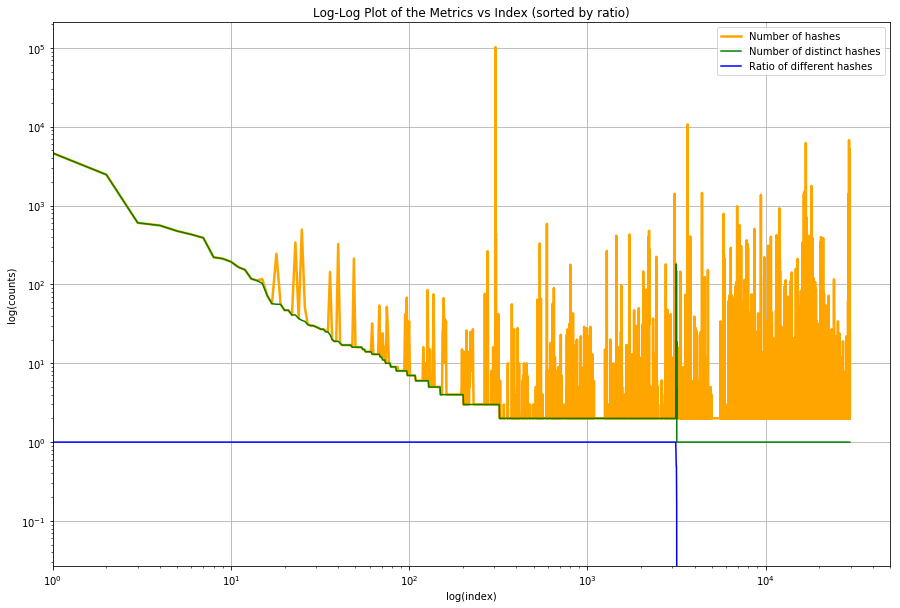

In [15]:
line0 = range(len(sorted_ratio) + 1)
line1 = np.insert(sorted_ratio['ratio_different'].values, 0, 1, axis=0)
line2 = np.insert(sorted_ratio['number_of_hashes'].values, 0, 1, axis=0)
line3 = np.insert(sorted_ratio['number_of_distinct_hashes'].values, 0, 1, axis=0)

plt.plot(line0,line2, linewidth=2.5,  color='orange')
plt.plot(line0,line3, color='green')
plt.plot(line0,line1, color='blue')

plt.title('Log-Log Plot of the Metrics vs Index (sorted by ratio)')
plt.ylabel('log(counts)')
plt.xlabel('log(index)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1)
plt.legend(["Number of hashes", "Number of distinct hashes", "Ratio of different hashes"])
plt.grid()
plt.show()

# Analyzing metrics

I generated the graphs above to help me visualize the results I obtain below. The graphs are all consistent in that there is almost an order of magnitude difference between the number of unique and number of identical downloads, with there being significantly more identical downloads.

First, I want to check how many of the URLs with multiple JS downloads actually downloaded the same file.

In [16]:
tmp = output_df

print("Of the {} ({:0.2f}%) files from the condensed dataset having multiple downloads,\nthere are {} ({:0.2f}%) files which download different files when given a query.".format(
        tmp.shape[0], 
        ratio1, 
        tmp[tmp['ratio_different'] > 0].shape[0],
        100 * tmp[tmp['ratio_different'] > 0].shape[0] / len(df.groupby('parent_filename').agg(['count'])))
     )

print("\nThis is compared to the {} ({:0.2f}%) urls with multiple queries downloading the same file.".format(
        tmp[tmp['ratio_different'] == 0].shape[0], 
        100 * tmp[tmp['ratio_different'] == 0].shape[0] / len(df.groupby('parent_filename').agg(['count'])))
     )

Of the 29714 (21.89%) files from the condensed dataset having multiple downloads,
there are 3175 (2.34%) files which download different files when given a query.

This is compared to the 26539 (19.56%) urls with multiple queries downloading the same file.


This shows that a very small portion of an already small portion of the total condensed file actually download different files when a unique query is given. 

I'll now check of that small set of URLs which download unique files. I also will add another criteria that there needs to be >= 3 total downloads, as there is a large tail of URLs with just one other file, and I want to investigate the behaviour of files with a larger number of downloads. 

In [17]:
different_downloads = tmp[(tmp['ratio_different'] > 0) & (tmp['number_of_hashes'] > 2)]
different_downloads = different_downloads.sort_values(
                                    by=['number_of_hashes'],
                                    ascending=False
                                )
different_downloads.head(20)

,number_of_distinct_hashes,number_of_hashes,parent_filename,ratio_different
17744,3,102349,staticxx-facebook-com-connect-xd-arbiter-r-ly4...,1.0
19628,4634,4634,tps30-doubleverify-com-visit-js.txt,1.0
14728,2468,2468,rtb0-doubleverify-com-verify-js.txt,1.0
29252,2,1413,z-moatads-com-cbsdfp5832910442-moatad-js.txt,1.0
945,604,604,apis-google-com-js-plusone-js.txt,1.0
3498,2,587,cdn-gl-imrworldwide-com-conf-config250-js.txt,1.0
19627,559,559,tps-doubleverify-com-visit-js.txt,1.0
5002,35,496,connect-facebook-net-en-us-sdk-js.txt,1.0
18225,2,479,t-sharethis-com-0-111-3632-a-t-js.txt,1.0
944,475,475,apis-google-com-js-platform-js.txt,1.0


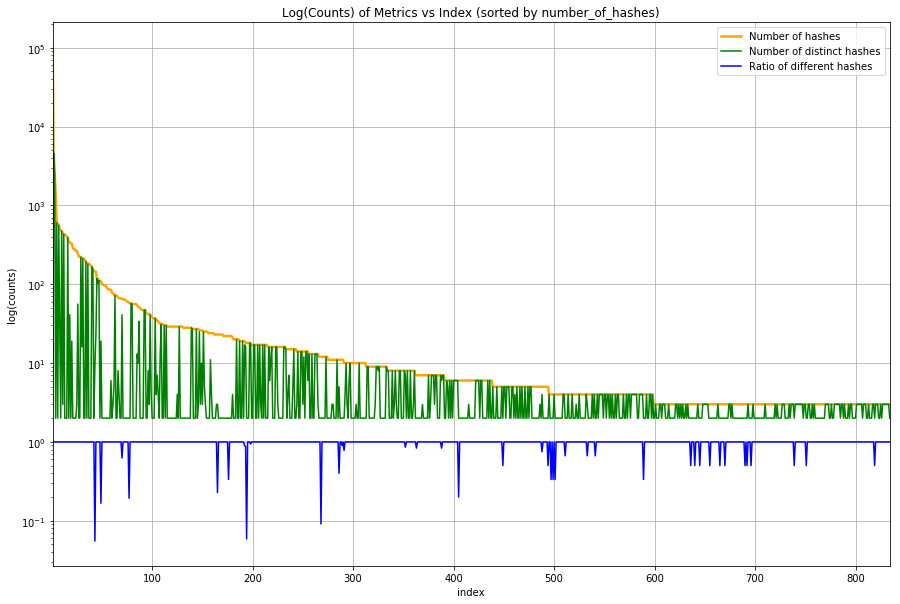

In [18]:
line0 = range(len(different_downloads) + 1)
line1 = np.insert(different_downloads['ratio_different'].values, 0, 1, axis=0)
line2 = np.insert(different_downloads['number_of_hashes'].values, 0, 1, axis=0)
line3 = np.insert(different_downloads['number_of_distinct_hashes'].values, 0, 1, axis=0)

plt.plot(line0,line2, linewidth=2.5,  color='orange')
plt.plot(line0,line3, color='green')
plt.plot(line0,line1, color='blue')

plt.title('Log(Counts) of Metrics vs Index (sorted by number_of_hashes)')
plt.ylabel('log(counts)')
plt.xlabel('index')
#plt.xscale('log')
plt.yscale('log')
plt.xlim(left=1,right=834)
plt.legend(["Number of hashes", "Number of distinct hashes", "Ratio of different hashes"])
plt.grid()
plt.show()

Paying attention to the x-axis no longer being log due to the smaller number of entries (y-axis still log). As we can see, there isn't a particularily clear trend. One observation is that:

1) The majority do have a `ratio_different` of 1, which means that **all** of the other downloaded JS files have different hashes, and 

2) The `number_of_distinct_hashes` tends to be either equal to `number_of_hashes` OR a relatively small number on the order of 10**1.  

If they have a `ratio_different` of 1 with only a small `number_of_distinct_hashes`, then this implies that *all requests with queries* request a different file than those without, wheras in the opposite scenario of having an equal `number_of_distinct_hashes` to `number_of_hashes` means that each of the downloaded file has a unique hash.

There's no more information that can be extracted via this hash method, so I had to manually compare a few samples to see how different the files are. I inspected a few manually, particularly the worst offenders:

**1) Some files from facebook:**
```
condensed_dataset/staticxx-facebook-com-connect-xd-arbiter-r-ly4ezxm-ywu-js.txt

full_dataset/staticxx-facebook-com-connect-xd-arbiter-r-ly4ezxm-ywu-js-version-42-channel-f21eb03725d459-origin-http-3a-2f-2fwww-independent-co-uk.txt
```

They were identical with the exception of some extra declarations of `self.emptyFunction=function()` at the beginning of the file, and the security url at the bottom (`<a href=...`)

**2) Some files from  tps30/doubleverify:**

These files do have some differences between them, should be worth investigating further. However, the majority of the script **is the same**. Seems like the query tweaks some parameters here and there. (mainly some `dv.tags`).



# Conclusion

Based on the brief manual investigation above revealing the similarties between downloaded JS files, and considering these files are a very small subset of the total dataset (where most files with multiple downloads have the same hashes), I think it's safe to focus on the condensed dataset for further analysis in this pipeline.

Additionally, I do think it is worth investigating the files individually for some of the other offenders such as tps30/doubleverify to see how different they really are based on the addition of queries.

# Some Diffs:

### Facebook

`diff condensed_dataset/staticxx-facebook-com-connect-xd-arbiter-r-ly4ezxm-ywu-js.txt full_dataset/staticxx-facebook-com-connect-xd-arbiter-r-ly4ezxm-ywu-js-version-42-channel-f21eb03725d459-origin-http-3a-2f-2fwww-independent-co-uk.txt
1c1`

```js
< <!DOCTYPE html><html><head><title>Facebook Cross-Domain Messaging helper</title></head><body><script>document.domain = 'facebook.com';__transform_includes = {};function emptyFunction() {};self.__DEV__=self.__DEV__||0,self.emptyFunction=function(){};
---
> <!DOCTYPE html><html><head><title>Facebook Cross-Domain Messaging helper</title></head><body><script>document.domain = 'facebook.com';__transform_includes = {};function emptyFunction() {};self.__DEV__=self.__DEV__||0;
57c57
< __d("initXdArbiter",["QueryString","resolveWindow","Log","XDM"],(function(a,b,c,d,e,f){__p&&__p();(function(){__p&&__p();var a=b("QueryString"),c=b("resolveWindow"),d=b("Log"),e=b("XDM");function f(a){return a?a.replace(/[\"\'<>\(\)\\@]/g,""):a}function g(){return!window.chrome||!location.ancestorOrigins?!1:!/\.facebook\.com$/.test(location.ancestorOrigins[1])}function h(a,b){if(g())return"";if(window!=parent&&window.parent!=window.parent.parent)try{return parent.parent.XdArbiter.register(window,a,b)}catch(a){d.error("Could not register with XdArbiter in parent.parent")}return""}function i(a,b,e){if(!a&&g()){d.error("Can not use parent.parent to reach facebook.com");return}var f=a?c(a):parent.parent;try{f.XdArbiter.handleMessage(b,e,window)}catch(b){d.error("Could not reach facebook.com using %s",a)}}function j(a,b){var c=50;b=function(){--c||clearInterval(d);try{a(),clearInterval(d)}catch(a){}};var d=setInterval(b,50);b()}function k(){var a=/^https?:\/\/[^\/]*/.exec(n.origin)[0];j(function(){var b=c(n.relation).frames["fb_xdm_frame_"+o];if(typeof b.location.search==="undefined")throw new Error("Proxy not ready");location.search===b.location.search?b.proxyMessage(m,a):d.error("Version mismatch: %s, %s",location.search,b.location.search)},50)}function l(){var a=/^(.*)\/(.*)$/.exec(n.origin)[1];if(window.__fbNative&&window.__fbNative.postMessage)window.__fbNative.postMessage(m,a);else{var b=function b(c){window.removeEventListener("fbNativeReady",b),window.__fbNative.postMessage(m,a)};window.addEventListener("fbNativeReady",b)}}var m=/#(.*)|$/.exec(document.URL)[1];m||(m=/#(.*)|$/.exec(window.location.href)[1]);window==top&&(location.hash="");if(!m){d.error("xd_arbiter.php loaded without a valid hash, referrer: %s",document.referrer);return}var n=a.decode(m,!0),o=location.protocol.replace(":","");if(window.name.substring(0,6)==="blank_"){parent.frames[n.forIframe].require("Arbiter").inform("blankIframeAck",window);return}if(n.relation){window==top&&/FBAN\/\w+;/i.test(navigator.userAgent)?(d.info("Native proxy"),l()):(d.info("Legacy proxy to %s",n.relation),k());return}if(o!=/https?/.exec(window.name)[0]){d.info("Redirection to %s detected, aborting",o);return}l=f(n.transport);var p=f(n.channel),q=f(n.origin),r=f(n.xd_name);if(!/^https?/.test(q)){d.error("Invalid origin presented, aborting.");return}e.create({root:document.body,transport:l,channel:p+"_"+o,onMessage:function(b,c){if(q!==c){d.info("Received message from unknown origin %s, expected %s.",c,q);return}/^FB_RPC:/.test(b)||(b=a.decode(b));i(b.relation,b,q)},whenReady:function(b){window.proxyMessage=function(a,c){c===q?b.send(a,q,parent,p):d.error("Failed proxying to %s, expected %s",c,q)};var c=null;c={xd_action:"proxy_ready",logged_in:/\bc_user=/.test(document.cookie),data:c};var e=h(r,q);e&&(c.registered=e);b.send(a.encode(c),q,parent,p)}})})()}),null);require("initXdArbiter"); require('initXdArbiter'); </script><b id="warning" style="display: none; color:red"> SECURITY WARNING: Please treat the URL above as you would your password and do not share it with anyone. See the <a href="https://l.facebook.com/l.php?u=https%3A%2F%2Fon.fb.me%2F1mXNHhm&amp;h=AT20DwaWLTlPR9XakcVVsp9P1EWh6_1oe_3yh7hYiLvsjnukP3lzNK_6v99LYK4CyesNRgLwSvfzN84G4SsVoJQIznoucKyzURe7xpJ7eyElA7OipWzA6EdjvZIbPcvm" target="_blank" rel="noopener nofollow" data-lynx-mode="asynclazy">Facebook Help Center</a> for more information. </b><script>if (window == top) {  setTimeout(function() {    document.getElementById("warning").style.display = 'block';  }, 2000);}</script></body></html>
\ No newline at end of file
---
> __d("initXdArbiter",["QueryString","resolveWindow","Log","XDM"],(function(a,b,c,d,e,f){__p&&__p();(function(){__p&&__p();var a=b("QueryString"),c=b("resolveWindow"),d=b("Log"),e=b("XDM");function f(a){return a?a.replace(/[\"\'<>\(\)\\@]/g,""):a}function g(){return!window.chrome||!location.ancestorOrigins?!1:!/\.facebook\.com$/.test(location.ancestorOrigins[1])}function h(a,b){if(g())return"";if(window!=parent&&window.parent!=window.parent.parent)try{return parent.parent.XdArbiter.register(window,a,b)}catch(a){d.error("Could not register with XdArbiter in parent.parent")}return""}function i(a,b,e){if(!a&&g()){d.error("Can not use parent.parent to reach facebook.com");return}var f=a?c(a):parent.parent;try{f.XdArbiter.handleMessage(b,e,window)}catch(b){d.error("Could not reach facebook.com using %s",a)}}function j(a,b){var c=50;b=function(){--c||clearInterval(d);try{a(),clearInterval(d)}catch(a){}};var d=setInterval(b,50);b()}function k(){var a=/^https?:\/\/[^\/]*/.exec(n.origin)[0];j(function(){var b=c(n.relation).frames["fb_xdm_frame_"+o];if(typeof b.location.search==="undefined")throw new Error("Proxy not ready");location.search===b.location.search?b.proxyMessage(m,a):d.error("Version mismatch: %s, %s",location.search,b.location.search)},50)}function l(){var a=/^(.*)\/(.*)$/.exec(n.origin)[1];if(window.__fbNative&&window.__fbNative.postMessage)window.__fbNative.postMessage(m,a);else{var b=function b(c){window.removeEventListener("fbNativeReady",b),window.__fbNative.postMessage(m,a)};window.addEventListener("fbNativeReady",b)}}var m=/#(.*)|$/.exec(document.URL)[1];m||(m=/#(.*)|$/.exec(window.location.href)[1]);window==top&&(location.hash="");if(!m){d.error("xd_arbiter.php loaded without a valid hash, referrer: %s",document.referrer);return}var n=a.decode(m,!0),o=location.protocol.replace(":","");if(window.name.substring(0,6)==="blank_"){parent.frames[n.forIframe].require("Arbiter").inform("blankIframeAck",window);return}if(n.relation){window==top&&/FBAN\/\w+;/i.test(navigator.userAgent)?(d.info("Native proxy"),l()):(d.info("Legacy proxy to %s",n.relation),k());return}if(o!=/https?/.exec(window.name)[0]){d.info("Redirection to %s detected, aborting",o);return}l=f(n.transport);var p=f(n.channel),q=f(n.origin),r=f(n.xd_name);if(!/^https?/.test(q)){d.error("Invalid origin presented, aborting.");return}e.create({root:document.body,transport:l,channel:p+"_"+o,onMessage:function(b,c){if(q!==c){d.info("Received message from unknown origin %s, expected %s.",c,q);return}/^FB_RPC:/.test(b)||(b=a.decode(b));i(b.relation,b,q)},whenReady:function(b){window.proxyMessage=function(a,c){c===q?b.send(a,q,parent,p):d.error("Failed proxying to %s, expected %s",c,q)};var c=null;c={xd_action:"proxy_ready",logged_in:/\bc_user=/.test(document.cookie),data:c};var e=h(r,q);e&&(c.registered=e);b.send(a.encode(c),q,parent,p)}})})()}),null);require("initXdArbiter"); require('initXdArbiter'); </script><b id="warning" style="display: none; color:red"> SECURITY WARNING: Please treat the URL above as you would your password and do not share it with anyone. See the <a href="https://l.facebook.com/l.php?u=https%3A%2F%2Fon.fb.me%2F1mXNHhm&amp;h=AT1WyAH3sXMbJtpD0IKHzYSAiCBzZ_qMorpGLOCS1QnSSH9CTzgwpWYugMmd8jlbhJYV4KYSiOhD3U-g0DQbOxO_GPTC-wbdKHjQ-pIYROjPLYr0bKJ1knV-7w" target="_blank" rel="nofollow" data-lynx-mode="origin">Facebook Help Center</a> for more information. </b><script>if (window == top) {  setTimeout(function() {    document.getElementById("warning").style.display = 'block';  }, 2000);}</script></body></html>
\ No newline at end of file
```

### tps30/doubleverify

These files do have some fairly significant differences between them, should be worth investigating further. However, the majority of the script **is the same**. Seems like the query tweaks some parameters here and there.


Condensed file:
`condensed_dataset/tps30-doubleverify-com-visit-js.txt`

Query file 1:
`full_dataset/tps30-doubleverify-com-visit-js-ctx-10609407-cmp-20360796-ipos-sid-3635412-plc-206176807-adid-crt-90163787-btreg-409152600-btadsrv-doubleclick-adsrv-1-advid-6417308-num-pid-crtname-unit-chnl-uid-1513449662788345-scusrid-tagtype-sr-dt-dup-app-dvvidver.txt`

Query file 2:
`full_dataset/tps30-doubleverify-com-visit-js-ctx-10609407-cmp-20360796-ipos-sid-3635412-plc-206176822-adid-crt-94064021-btreg-406148029-btadsrv-doubleclick-adsrv-1-advid-6417308-num-pid-crtname-unit-chnl-uid-1513402355743123-scusrid-tagtype-sr-dt-dup-app-dvvidver.txt
`

***Condensed file has:***
```js
$dv.tags[$uid].set({
    "bgm": 1
});
```


***Query file 1 has the following prepended to the condensed script:***
```js
try {
    var dv_win = window._dv_win || window.parent._dv_win;
    dv_win['dvCallback_1513449663000160']($dv, window, '675867cdc1e4428993973b4a9d5e87f8', 'tps11003.doubleverify.com');
} catch (e) {
    try {
        var image = window.document.createElement('img');
        image.src = window.location.protocol + '//tps30.doubleverify.com/visit.jpg?ctx=818052&cmp=1619415&dvtagver=6.1.src&dvp_cbError=' + encodeURIComponent(e.message)
    } catch (e) {}
}

...


$dv.tags[$uid].set({
    "cvmSettings": {
        "adArea": "50",
        "duration": "1000",
        "measureType": "Consecutive",
        "focus": "1"
    }
});
$dv.tags[$uid].dc = $dv.tags[$uid].dc || [];
$dv.tags[$uid].dc.push({
    "rq": {
        "av": 50,
        "ic": 1,
        "fc": 1,
        "adc": 1000
    },
    "rp": {
        "pt": "iscvmvms",
        "pr": "CustomViewabilityViewable",
        "eid": 6
    }
});
$dv.pubSub.subscribe('ImpressionServed', $uid, 'SendAdEntitiesForBSBAConsolidation', function() {
    'use strict';
    var stringifyFunc = null;
    if (window.JSON) {
        stringifyFunc = window.JSON.stringify;
    } else {
        if (window.parent && window.parent.JSON) {
            stringifyFunc = window.parent.JSON.stringify;
        }
    }
    if (!stringifyFunc) {
        return;
    }
    var targetWin;
    var tag = $dv.tags[$uid];
    var bsmsg = {
        action: 'notifyBrandShieldAdEntityInformation',
        bsAdEntityInformation: {
            comparisonItems: [{
                name: 'cmp',
                value: 11640719
            }, {
                name: 'plmt',
                value: 11640751
            }],
            verboseReporting: true
        }
    };
    var bsstring = stringifyFunc(bsmsg);

    var findAndSend = function() {
        if (!targetWin) {
            if (tag) {
                targetWin = tag.t2tIframeWindow;
                if (!targetWin) {
                    var t2tIframeId = tag.t2tIframeId;
                    //get t2t window and post the AdEntities to it.
                    if (t2tIframeId) {
                        var iFrame = window.parent.getElementById(t2tIframeId);
                        if (iFrame) {
                            targetWin = iFrame.contentWindow;
                        }
                    }
                }
            }
        }

        if (targetWin) {
            targetWin.postMessage(bsstring, '*');
        }
    };

    findAndSend();
    setTimeout(findAndSend, 100);
    setTimeout(findAndSend, 500);
});
$dv.tags[$uid].set({
    "bgm": 1
});

```

**Query file 2 has the following prepended to the condensed script:**
```js
try {
    var dv_win = window._dv_win || window.parent._dv_win;
    dv_win['dvCallback_1513402355822249']($dv, window, 'b268df6107c44b4e8ba924a125028b35', 'tps11018.doubleverify.com');
} catch (e) {
    try {
        var image = window.document.createElement('img');
        image.src = window.location.protocol + '//tps30.doubleverify.com/visit.jpg?ctx=818052&cmp=1619415&dvtagver=6.1.src&dvp_cbError=' + encodeURIComponent(e.message)
    } catch (e) {}
}

...
         

$dv.tags[$uid].set({
    "cvmSettings": {
        "adArea": "50",
        "duration": "1000",
        "measureType": "Consecutive",
        "focus": "1"
    }
});
$dv.tags[$uid].dc = $dv.tags[$uid].dc || [];
$dv.tags[$uid].dc.push({
    "rq": {
        "av": 50,
        "ic": 1,
        "fc": 1,
        "adc": 1000
    },
    "rp": {
        "pt": "iscvmvms",
        "pr": "CustomViewabilityViewable",
        "eid": 6
    }
});
$dv.pubSub.subscribe('ImpressionServed', $uid, 'SendAdEntitiesForBSBAConsolidation', function() {
    'use strict';
    var stringifyFunc = null;
    if (window.JSON) {
        stringifyFunc = window.JSON.stringify;
    } else {
        if (window.parent && window.parent.JSON) {
            stringifyFunc = window.parent.JSON.stringify;
        }
    }
    if (!stringifyFunc) {
        return;
    }
    var targetWin;
    var tag = $dv.tags[$uid];
    var bsmsg = {
        action: 'notifyBrandShieldAdEntityInformation',
        bsAdEntityInformation: {
            comparisonItems: [{
                name: 'cmp',
                value: 11640719
            }, {
                name: 'plmt',
                value: 11640839
            }],
            verboseReporting: false
        }
    };
    var bsstring = stringifyFunc(bsmsg);

    var findAndSend = function() {
        if (!targetWin) {
            if (tag) {
                targetWin = tag.t2tIframeWindow;
                if (!targetWin) {
                    var t2tIframeId = tag.t2tIframeId;
                    //get t2t window and post the AdEntities to it.
                    if (t2tIframeId) {
                        var iFrame = window.parent.getElementById(t2tIframeId);
                        if (iFrame) {
                            targetWin = iFrame.contentWindow;
                        }
                    }
                }
            }
        }

        if (targetWin) {
            targetWin.postMessage(bsstring, '*');
        }
    };

    findAndSend();
    setTimeout(findAndSend, 100);
    setTimeout(findAndSend, 500);
});
$dv.tags[$uid].set({
    "bgm": 1
});
         
```